In [1]:
import networkx as nx
from torch_geometric.utils.convert import from_networkx
import training.training as tt
import pyvista
import numpy as np
import torch
from visualization import mesh_viewer

## This should showcase how different methods split the data and what the disadvantages and advantages of the different methods are

#### Loading the data

In [3]:
# load the pickled graph
G_load = nx.read_gpickle("saved_data/graph_gt_pickle")

char_class_reverse = {}
char_class_reverse["n"] = 0
char_class_reverse["l"] = 1

GX_load = from_networkx(G_load)
GX_load.y = torch.tensor([char_class_reverse[elem[-1]] for elem in G_load.nodes()])
print(GX_load)

Data(x=[3715, 0], edge_index=[2, 10200], pos=[3715, 3], edge_x=[10200, 17], y=[3715])


#### Splitting the data and looking at the distributions

In [4]:
# create a trainer with slicing by z axis 
# slicing along any other axis than y does not really make sense - y slicing goes along the path of the intestine

Splitter = tt.Splitter(GX_load)
trainX,testX, split_valueX = Splitter.split_geometric((0,0,1), frac = 0.8)
trainY,testY, split_valueY = Splitter.split_geometric((0,1,0), frac = 0.8)
trainZ,testZ, split_valueZ = Splitter.split_geometric((1,0,0), frac = 0.8)


# obvious problem: test set has way more nerve nodes than training set: <50% vs >100%
print("##### Z-Split #####")
print(np.unique(GX_load.y[trainX], return_counts= True))
print(np.unique(GX_load.y[testX], return_counts= True))

# for y the ratio is more stable - 53% vs 56%
print("##### Y-Split #####")
print(np.unique(GX_load.y[trainY], return_counts= True))
print(np.unique(GX_load.y[testY], return_counts= True))

# for x the ratio is worse than for y - 48% vs 82%
print("##### X-Split #####")
print(np.unique(GX_load.y[trainZ], return_counts= True))
print(np.unique(GX_load.y[testZ], return_counts= True))

##### Z-Split #####
(array([0, 1]), array([ 901, 2071]))
(array([0, 1]), array([407, 336]))
##### Y-Split #####
(array([0, 1]), array([1033, 1939]))
(array([0, 1]), array([275, 468]))
##### X-Split #####
(array([0, 1]), array([ 972, 2000]))
(array([0, 1]), array([336, 407]))


#### Slicing on the X-Axis

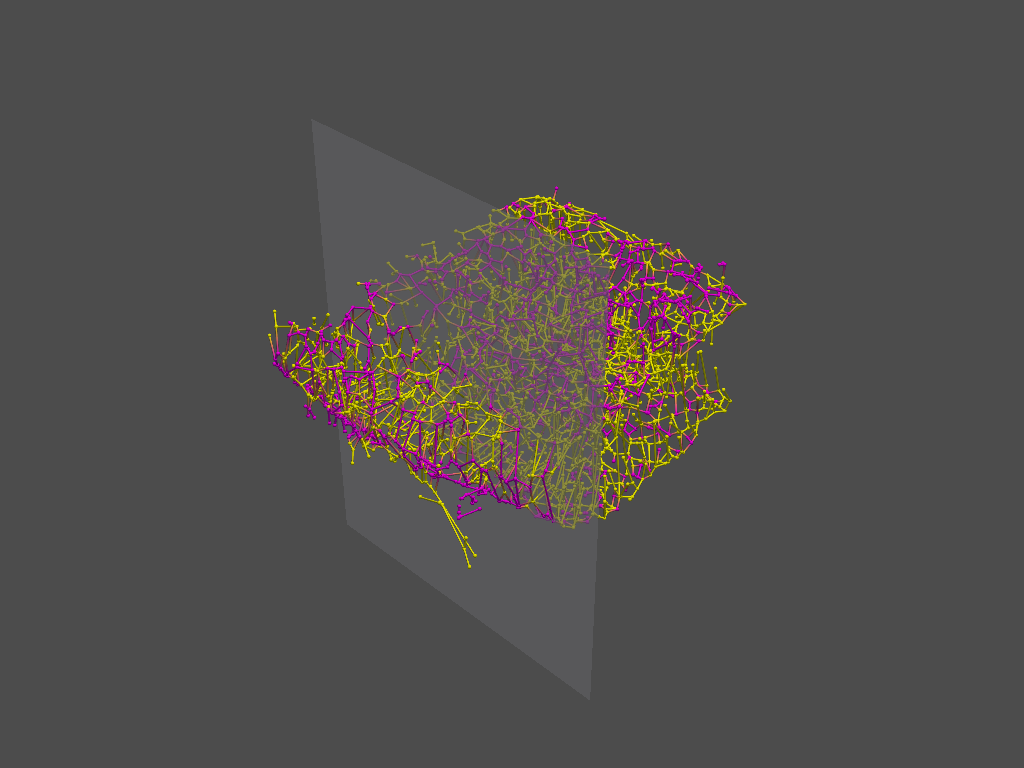

In [4]:
pyvista.set_jupyter_backend('static')  
p = pyvista.Plotter()
center = (split_valueX, 0, 0)

mesh = pyvista.Plane(center=center, direction=(1,0,0), i_size=4, j_size=3, i_resolution=1, j_resolution=1)
mesh.point_data.clear()
p.add_mesh(mesh, opacity = 0.6)
actor_list = mesh_viewer.renderNXGraph(G_load, dual = False, vtk = 0,get_actors= True)
for actor in actor_list:
    p.add_actor(actor)
p.show()

#### Slicing on the Y-Axis

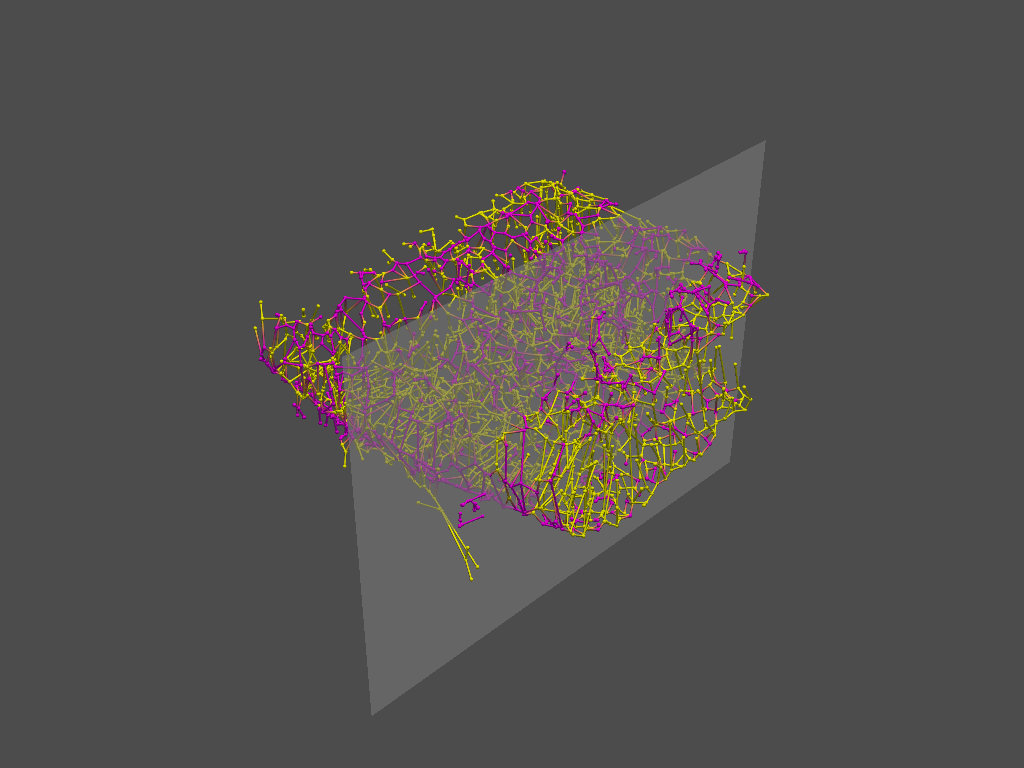

In [5]:
pyvista.set_jupyter_backend('static')  
p = pyvista.Plotter()
center = (0, split_valueY, 0)

mesh = pyvista.Plane(center=center, direction=(0,1,0), i_size=4, j_size=3, i_resolution=1, j_resolution=1)
mesh.point_data.clear()
p.add_mesh(mesh, opacity = 0.6)
actor_list = mesh_viewer.renderNXGraph(G_load, dual = False, vtk = 0,get_actors= True)
for actor in actor_list:
    p.add_actor(actor)
p.show()

#### Slicing on the Z-Axis

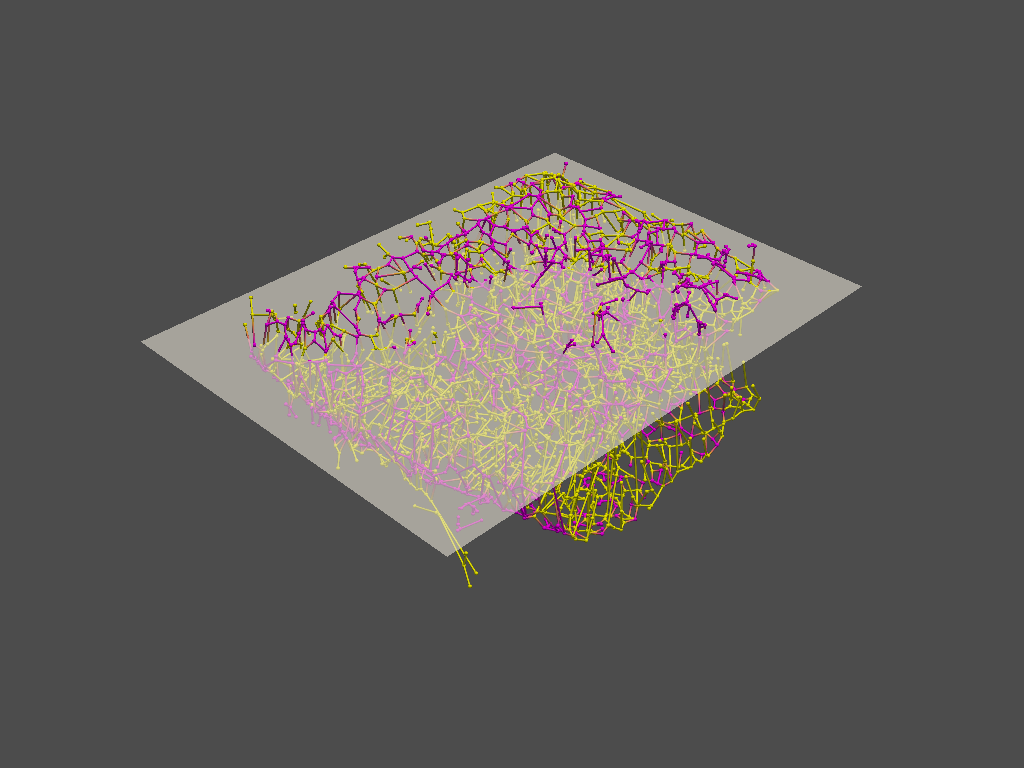

In [6]:
pyvista.set_jupyter_backend('static')  
p = pyvista.Plotter()
center = (0, 0, split_valueZ)

mesh = pyvista.Plane(center=center, direction=(0,0,1), i_size=4, j_size=3, i_resolution=1, j_resolution=1)
mesh.point_data.clear()
p.add_mesh(mesh, opacity = 0.6)
actor_list = mesh_viewer.renderNXGraph(G_load, dual = False, vtk = 0,get_actors= True)
for actor in actor_list:
    p.add_actor(actor)
p.show()

#### Splitting randomly - green represents the test node and red the train nodes

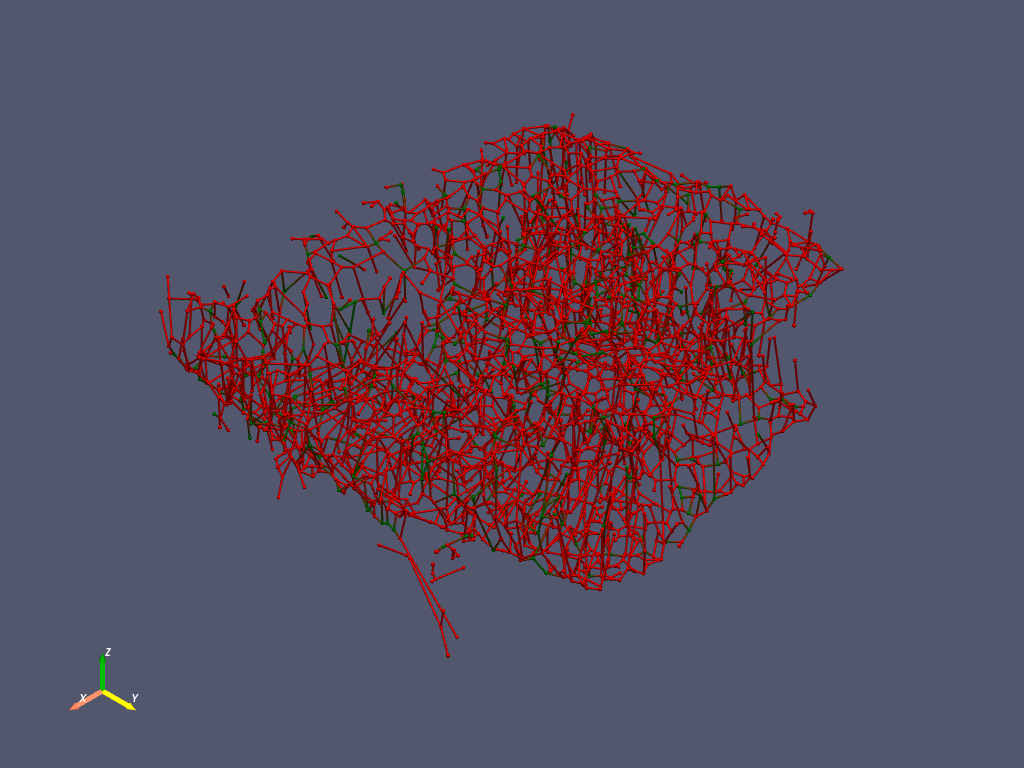

In [7]:
trainR,testR = Splitter.split_random(frac = 0.9, seed = 12345)
test_nodes = np.array(list(G_load.nodes()))[testR]
train_nodes = np.array(list(G_load.nodes()))[trainR]
rename_test_dict = dict(zip(test_nodes, [tn + "r" for tn in test_nodes]))
rename_train_dict = dict(zip(train_nodes, [tn + "f" for tn in train_nodes]))
G_random = nx.relabel_nodes(G_load, rename_test_dict)
G_random = nx.relabel_nodes(G_random, rename_train_dict)

mesh_viewer.renderNXGraph(G_random, dual = False, vtk = 0,backend= "static")